Import packages and reference data

In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
%matplotlib inline
from nustar_scripts.pulsar_init import ObsList_bright, mjd_val, MJD_REF, Nu_path, plot_path, ObsAlias, analysis_path
from nustar_scripts.nu_utils import set_mpl
set_mpl()


# Light curve

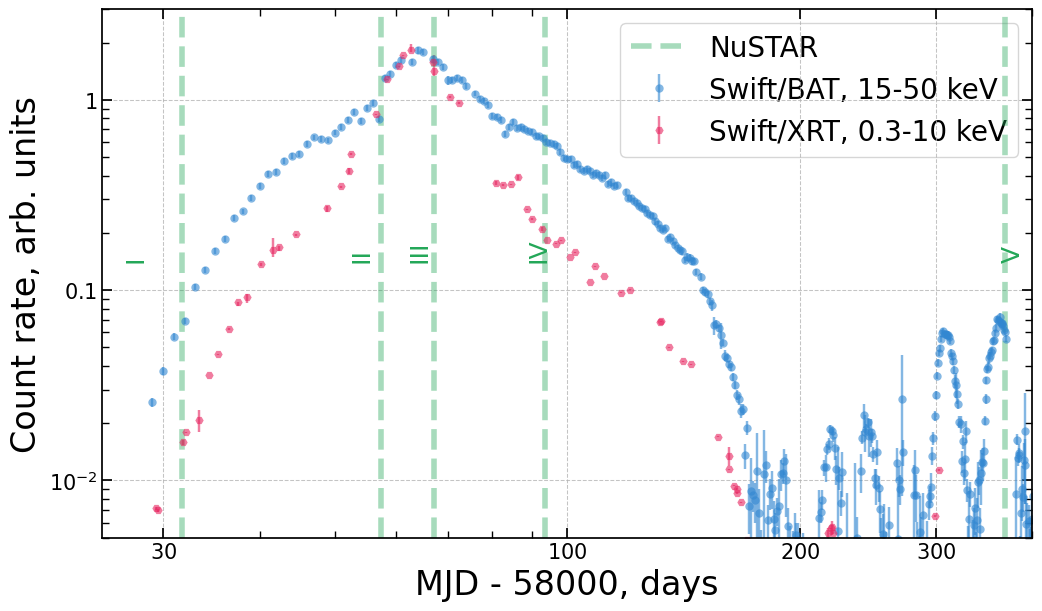

In [8]:

bat_lc = np.genfromtxt(Nu_path + "nustar_data/BAT_SwiftJ0243.txt")
bat_mjd = bat_lc[:, 0]
bat_rate = bat_lc[:, 1]
bat_error = bat_lc[:, 2]

xrt_lc = np.genfromtxt(Nu_path + "nustar_data/XRT_SwiftJ0243.txt", comments ='!')
xrt_mjd = xrt_lc[:,0]
xrt_rate = xrt_lc[:,3]
xrt_error = np.vstack((xrt_lc[:,4],-xrt_lc[:,5]))
factor = 1/np.max(xrt_rate)*np.max(bat_rate) #normalize the BAT and XRT light curves
xrt_rate = xrt_rate*factor
xrt_error = xrt_error*factor


fig, ax = plt.subplots(figsize=[12, 7])  # type: ignore
ax.errorbar(bat_mjd-MJD_REF, bat_rate, bat_error,
            label="Swift/BAT, 15-50 keV", color="C0", fmt = 'o', ms = 6, alpha = 0.6)

ax.errorbar(xrt_mjd-MJD_REF, xrt_rate, xrt_error,
            label="Swift/XRT, 0.3-10 keV", color="C1", fmt = 'H', ms = 6, alpha = 0.6)


for ii, ObsID in enumerate(ObsList_bright):
    mjd = mjd_val[ObsID]-MJD_REF
    ax.axvline(
        mjd,
        label = None if ii!=0 else 'NuSTAR',
        color = 'C2',
        lw=4,
        ls='--',
        alpha = 0.4,
    )
    ax.annotate(ObsAlias[ObsID].split()[0], (mjd-5, 0.15), color = 'C2', fontsize = 18, rotation = 90)

ax.set_xlim(25, 400)
ax.set_ylim(5e-3, 3)
ax.set_xlabel(f"MJD - {MJD_REF}, days", fontsize = 24)
ax.set_ylabel("Count rate, arb. units", fontsize = 24)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks([30,100,200, 300])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
l = ax.legend(fontsize = 20)
l.set_zorder(-1)

plt.show()
fig.tight_layout()
fig.savefig(plot_path+ 'lightcurve.pdf')


# Pulse profiles

Obs 90302319002: pulse profile  PF = 0.2939160466194153; R = 0.8325244188308716
Obs 90302319004: pulse profile  PF = 0.4508432149887085; R = 1.6419472694396973
Obs 90302319006: pulse profile  PF = 0.5425513386726379; R = 2.3720755577087402
Obs 90302319008: pulse profile  PF = 0.3188793957233429; R = 0.9363374710083008
Obs 90401334002: pulse profile  PF = 0.31538838148117065; R = 0.921364426612854


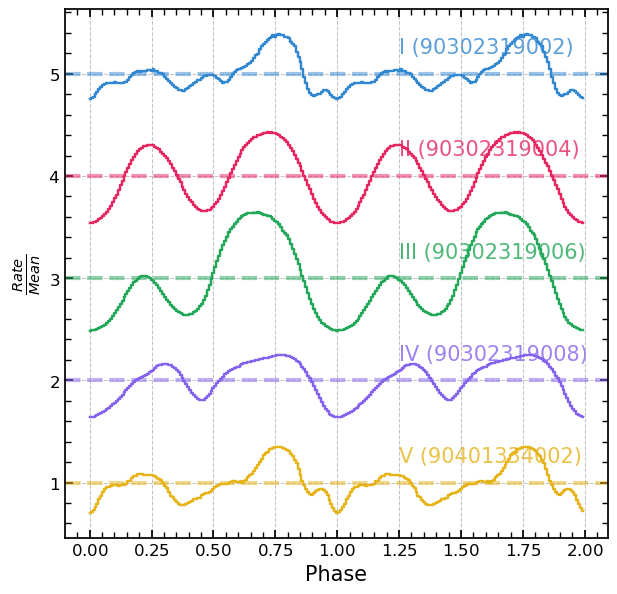

In [11]:

fig, ax = plt.subplots(figsize=[7, 7])  # type: ignore


def pf_and_relative_var(observable: np.ndarray):
    """ calculate the pulsed fraction PF of an observable and the relative variability R
    PF = (max - min) / (max+min)
    R = max/min -  1
    """
    o_min = np.min(observable)
    o_max = np.max(observable)
    pf = (o_max-o_min)/(o_max+o_min)
    rel = o_max/o_min - 1 
    return pf, rel

for ii, ObsID in enumerate(ObsList_bright):
    ii = len(ObsList_bright)-ii - 1
    f   = fits.open(f'{analysis_path}out{ObsID}/products/spe_and_lc/spe_and_lcAB_sr.lc_bary_orb_corr_nphase_128.efold')

    ph, rate, err = f[1].data['PHASE'],  f[1].data['RATE1'],  f[1].data['ERROR1']
    roll_idx = -np.argmin(rate)

    rate = np.roll(rate, roll_idx)
    err = np.roll(err, roll_idx)

    #tile  to plot two phase intervals
    rate = np.tile(rate, 2)
    err = np.tile(err, 2)
    ph = np.hstack((ph, ph+1))


    factor = np.mean(rate)
    rate = rate/factor
    err = err/factor

    
    pf, R  = pf_and_relative_var(rate)
    print(f'Obs {ObsID}: pulse profile  PF = {pf}; R = {R}')


    ax.step(ph, rate+ii, where='mid', label=ObsAlias[ObsID])
    color =  ax.get_lines()[-1].get_color()
    ax.errorbar(ph, rate+ii, err, fmt = 'none', color= color, ms = 10, alpha = 0.5)
    ax.axhline(ii+1, color = color, alpha = 0.5, ls = '--', lw = 3)
    ax.annotate(ObsAlias[ObsID], (1.25, 1+ii+0.2), fontsize = '15', zorder = -1, color = color, alpha = 0.8)


ax.set_xlabel(f"Phase")
ax.set_ylabel(r"$\frac{Rate}{Mean}$")

plt.show()
fig.tight_layout()
fig.savefig(plot_path+ 'pulse_profiles.pdf')

